# CCRESS Training School - MUNICH 2025
### STRATfinder : an automated detection algorithm of the mixed layer height
#### NoteBook 2/2 : MLH Analysis - Climatology & Urban effect

This NoteBook provides a tool to analyse mixed-layer height (MLH) results derived from automatic lidar and ceilometers (ALC) observations using the STRATfinder tool (see NoteBook 1/2).

All results are obtained in the framework of the ABL testbed project (https://ablh.aeris-data.fr/)

Analysis provides some insights in temporal and spatial variations of MLH:

a) a first comparison between STRATfinder MLH (aerosol-based MLH) with MLH retrieved from Doppler Wind lidar (DWL) observations of vertical velocity variance, a common measurement of vertical mixing derived from continuous vertical stare observations.

b) case studies of MLH results in Paris and Rotterdam are compared to further explore regional variability in MLH.

c) multi-year MLH results at different European sites are compared

#### M. Van Hove, IPSL & S. Kotthaus, Ecole Polytechnique 
#### Contact : mvanhove@ipsl.fr

In [18]:
#1

## ---------- Import librarires ------------
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

from datetime import date, timedelta, time
from pvlib.location import Location

from functions import get_sr_ss, get_med, from_df_to_pivot, plot_MLH


In [19]:
## -------- Path to data ----------- 

path_data = "/data/ACTRIS-CCRES/abl_heights/"

## Doppler Wind Lidar (DWL) VS CL61

Layer heights obtained based on turbulence vs aerosol profiles

Comparison between two methods

A) turbulence-based detection: profiles of vertical velocity variance (Doppler wind lidar - Vaisala WCS400s)

B) aerosol-based detection: profiles of attenuated backscatter signal (ALC - Vaisala CL61)

In [20]:
#2

## ----------- Load data -----------

### =========== CL61 ==============
# The CL61 provide attenuated backscatter from first gate to 15km 
# No correction should be required according to Vaisala, although a near-range correction is in progress at SIRTA  

# raw signal : L1 files
L1_CL61 =  xr.open_dataset(f"{path_data}/cl61_1a_HOTE_v01_20220702_000000_1440.nc").rcs_0.to_dataframe()

# Mixed layer height derived by STRATfinder (MLH)
MLH_CL61 = xr.open_dataset(f"{path_data}/cl61_1a_HOTE_v01_20220702_000000_1440_L2A_140.nc").to_dataframe()

#
### ============ W400S DWL =============

## ------------- load variance data ------------
variance_field = xr.open_dataset(f"{path_data}/data_20220702_test.nc").sigma_w.to_dataframe()
variance_field = variance_field[~variance_field.index.duplicated(keep='first')]

## ------------- load MLH data --------------
MLH_ws400_flag = pd.read_csv(f"{path_data}/MLH_ws400_2022_flag_rain.csv")
MLH_ws400_flag = MLH_ws400_flag.set_index("time")
MLH_ws400_flag.index = pd.to_datetime(MLH_ws400_flag.index)
MLH_ws400_flag = MLH_ws400_flag.MLH


In [21]:
#3
## -------- Make data easier to handle and lighter ------------

L1_CL61 = from_df_to_pivot(L1_CL61, "rcs_0", 1)
L1_CL61 = L1_CL61.loc[:3000]

MLH_CL61 = MLH_CL61.droplevel("station")
MLH_CL61 = MLH_CL61.MLH.resample("15min").mean()

variance_field = from_df_to_pivot(variance_field, "sigma_w", 0)

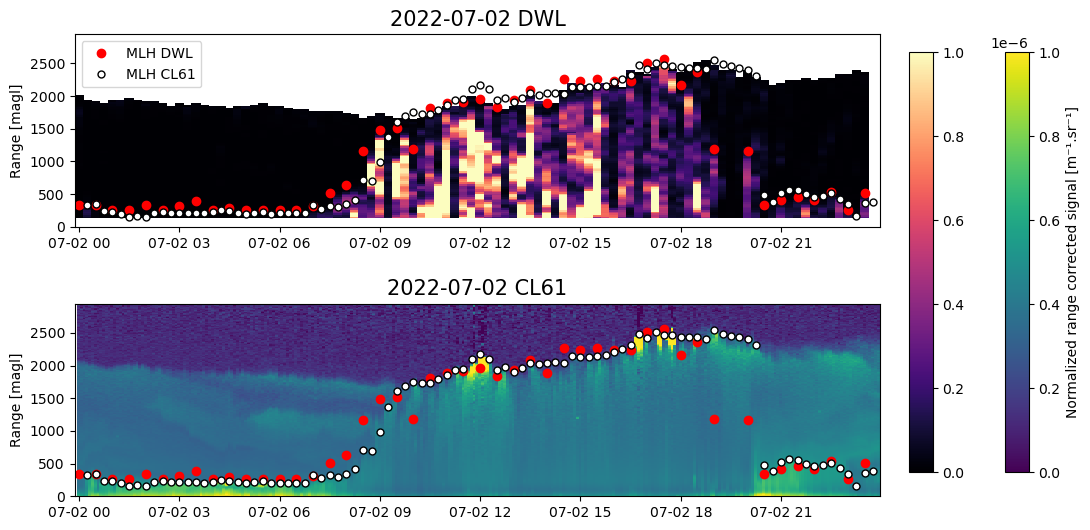

In [22]:
#4
date_ = date(2022, 7, 2)
field1 = variance_field
field2 = L1_CL61 
site1 = "DWL"
site2 = "CL61"
MLH_ws400_flag = MLH_ws400_flag[MLH_ws400_flag.index.date == date_]

data = {
    f"MLH_{site1}": list(MLH_ws400_flag),
    f"MLH_{site2}": list(MLH_CL61),
}

df = pd.DataFrame(data, index = MLH_CL61.index)

vmin1 = 0
vmin2 = 0
vmax1 = 1 * 10**0
vmax2 = 1 * 10**-6

plot_MLH(date_, field1, field2, site1, site2, df, vmin1, vmin2, vmax1, vmax2, 1, 0, "magma")

The turbulence-derived mixing height from DWL observations appears to rise slightly earlier in the morning than the aerosol-based layer height on some case study days. 

This has also been found in the literature (e.g. Kotthaus et al. 2018).



## Urban case study #1: Continental climate, flat terrain
Urban site: Paris
Suburban site: SIRTA (~25 km Southwest of the city)

In [23]:
#5
## --------- Load data -----------

MLH_palaiseau = xr.open_mfdataset(f"{path_data}/eprofile_L2B_STRATFINDER_palaiseau_chm15k-B_v01_2022071*.nc").MLH.to_dataframe()
MLH_paris = xr.open_mfdataset(f"{path_data}/eprofile_L2B_STRATFINDER_qualair_chm15k-A_v01_2022071*.nc").MLH.to_dataframe()
MLH_palaiseau = MLH_palaiseau.droplevel("station_name").resample("15min").mean()
MLH_paris = MLH_paris.droplevel("station_name").resample("15min").mean()

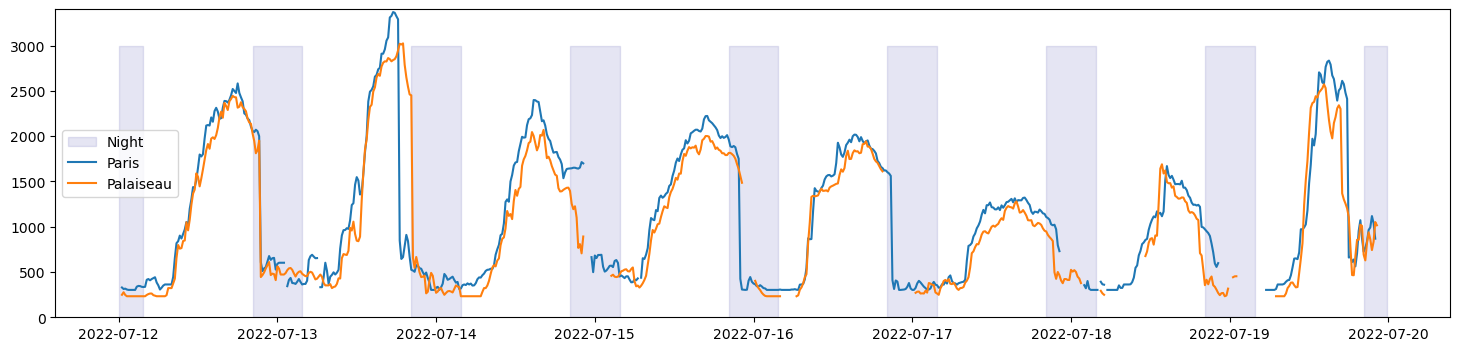

In [24]:
#6
## --------- Plot time serie in summer -------------

df_urban = MLH_paris[MLH_paris.index.date >= date(2022,7,12)]
df_suburban = MLH_palaiseau[MLH_palaiseau.index.date >= date(2022,7,12)]

fig, ax = plt.subplots(figsize=(18, 4)) 

ax.fill_between(df_urban.index, -0, 3000,
                where=((df_urban.index.time < time(4,0,0)) | (df_urban.index.time > time(20,0,0))), alpha=0.1, color='darkblue',
                label='Night')
ax.set_ylim([0,3400])

ax.plot(df_urban.MLH, label = "Paris")
ax.plot(df_suburban.MLH, label = "Palaiseau")

plt.legend()

Visible urban effect : higher MLH in the city center

Influence of the wind :

NE (SIRTA downwind the city center) : lower delta MLH => stronger winds, homogenization of the atmosphere (aerosols, temperature, humidity...)

SW (SIRTA upwind the city center) : higher delta MLH => lower winds, less mixing

Consistent with D. Looschelders (University of Freiburg)


## Urban case study #2: Marine influence
Urban site: Rotterdam
Rural site: Cabauw (~20 km East of the city)

In [25]:
#7
## ----------- Load data ----------------

signal_cabauw = xr.open_dataset(f"{path_data}/eprofile_BSC_STRATFINDER_cabauw_chm15k-A_v01_20220811.nc").beta.to_dataframe()
signal_rotterdam = xr.open_dataset(f"{path_data}/eprofile_BSC_STRATFINDER_rotterdam_chm15k-Y_v01_20220811.nc").beta.to_dataframe()
MLH_cabauw = xr.open_dataset(f"{path_data}/eprofile_L2B_STRATFINDER_cabauw_chm15k-A_v01_20220811.nc").MLH.to_dataframe()
MLH_rotterdam = xr.open_dataset(f"{path_data}/eprofile_L2B_STRATFINDER_rotterdam_chm15k-Y_v01_20220811.nc").MLH.to_dataframe()

In [26]:
#8
## ---------- Make data easier to handle ---------

signal_cabauw = from_df_to_pivot(signal_cabauw, "beta", 1)
signal_rotterdam = from_df_to_pivot(signal_rotterdam, "beta", 1)

MLH_cabauw = MLH_cabauw.droplevel("station_name").resample("15min").mean()
MLH_rotterdam = MLH_rotterdam.droplevel("station_name").resample("15min").mean()

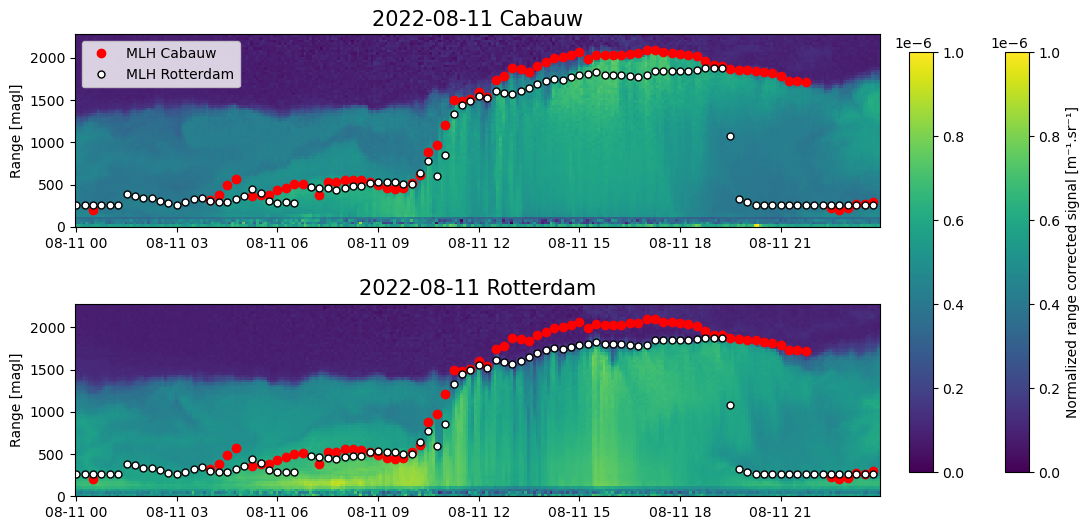

In [27]:
#9
## ----------- Plot attenuated backscatter signal & MLH ---------------

date_ = date(2022, 8, 11)
field1 = signal_cabauw
field2 = signal_rotterdam
site1 = "Cabauw"
site2 = "Rotterdam"

data = {
    "MLH_Cabauw": list(MLH_cabauw.MLH),
    "MLH_Rotterdam": list(MLH_rotterdam.MLH),
}

df = pd.DataFrame(data, index = MLH_rotterdam.index)

vmin1 = 0
vmin2 = 0
vmax1 = 1 * 10**-6
vmax2 = 1 * 10**-6

plot_MLH(date_, field1, field2, site1, site2, df, vmin1, vmin2, vmax1, vmax2, 1, 0, "viridis")

Unexpected result : higher MLH in the rural environment

Marine influence ? 

## European MLH climatology in summer

In [28]:
#10
## -------- Load data -------------

### ========= CHM15k ==============
# MLH from : 
# Palaiseau 2015 - 2024 (France) 
# Cabauw 2018 - 2024 (Rotterdam, Netherlands) 
# Magurele 2019 - 2024 (Bucharest, Romania)
# Granada 2018 - 2024 (Spain)

sites = ["palaiseau", "cabauw", "magurele", "granada"]

dict_MLH = {} 
dict_lat = {}
dict_lon = {}

for site in sites :
    dict_MLH[f"MLH_{site}"] = pd.read_csv(f"{path_data}/MLH_{site}.csv")
    dict_lat[f"lat_{site}"] = float(xr.open_mfdataset(f"{path_data}/eprofile_L2B*{site}*2022*_15min.nc").station_latitude[0].values)
    dict_lon[f"lon_{site}"] = float(xr.open_mfdataset(f"{path_data}/eprofile_L2B*{site}*2022*_15min.nc").station_longitude[0].values)
    dict_MLH[f"MLH_{site}"] = dict_MLH[f"MLH_{site}"].drop(columns = ["station_name"])
    dict_MLH[f"MLH_{site}"] = dict_MLH[f"MLH_{site}"].set_index("time")
    dict_MLH[f"MLH_{site}"].index = pd.to_datetime(dict_MLH[f"MLH_{site}"].index)


In [29]:
#11
## -------- Get median diurnal cycle for summer ----------

for site in sites :
    dict_MLH[f"MLH_{site}"] = get_sr_ss(site, dict_MLH, dict_lat, dict_lon)
    dict_MLH[f"MLH_{site}_jja"] = get_med(site, "MLH", dict_MLH, dict_lat, dict_lon)

In [30]:
dict_MLH[f"MLH_cabauw_jja"]

,time_relSR,mlh,q1,q3,max_mlh,nsamples
0,-10.25,818.180005,403.095493,1147.350507,2064.931934,20
1,-10.00,844.153998,551.446994,1201.296515,2154.842008,40
2,-9.75,862.135999,629.368992,1300.697030,2176.820036,47
3,-9.50,794.203994,485.512998,1151.845982,2866.129883,78
4,-9.25,734.263997,388.609996,963.034998,2292.703955,79
...,...,...,...,...,...,...
103,15.50,931.066996,596.901489,1427.569946,2958.038037,266
104,15.75,882.115999,526.471989,1367.630005,2880.115999,261
105,16.00,852.145996,487.510993,1308.688997,2870.126009,215
106,16.25,786.212000,468.529995,1263.733984,2694.302051,201


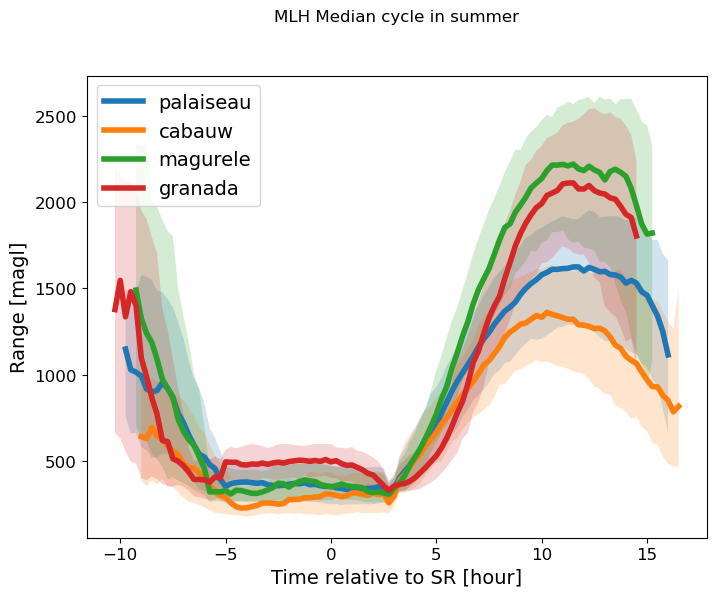

In [31]:
#12

## -------- Plot MLH median cycles ----------
fig = plt.figure(figsize=(8, 6))

plt.title("MLH Median cycle in summer",  y=1.1)
lim = 100
for site in sites :
    df = dict_MLH[f"MLH_{site}_jja"].copy()
    plt.plot(df.time_relSR[df.nsamples > lim], df.mlh[df.nsamples > lim], label=f'{site}', linewidth = 4)
    plt.fill_between(df[df.nsamples > lim].time_relSR, df[df.nsamples > lim].q3, df[df.nsamples > lim].q1, alpha=0.2)

plt.xlabel("Time relative to SR [hour]",fontsize=14)
plt.ylabel("Range [magl]", fontsize=14)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend(fontsize=14, loc="upper left")



Clear correlation with type of climate 

Higher MLH in warmer / dryer cities

Granada : different morning growth, higher nocturnal layer (quality control? real values?), proximity with saharian desert : external source of aerosols ?